In [1]:
import pandas as pd
import random
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tqdm import tqdm
import pickle

In [2]:
# game data outputted from W1_DataCleaning.ipynb, with stats, goes back to 2010
game_data = pd.read_csv('mydata/womens/matchups.csv')
game_data.head()

,Season,MooreRating_x,MooreRating_y,Seed_x,3ptRate_x,Ast%_x,FT%_x,OppFT%_x,Opp3ptRate_x,OppAst%_x,...,xOffyOffFTRateDiff,AbsxOffyDefAstDiff,AbsyOffxDefAstDiff,xOffyDefAstAvg,yOffxDefAstAvg,xOffyOffAstDiff,TotalPossVarSum,GameScoreVarSum,AvgTotalPoss,MooreNaiveUpsetProbability
0,2010.0,91.81,78.17,4,0.153633,0.562874,0.726562,0.687204,0.318363,0.449704,...,0.103332,0.046362,0.116533,0.539693,0.507970,0.031723,323.329209,249.795260,142.390152,0.111138
1,2010.0,91.81,82.29,4,0.153633,0.562874,0.726562,0.687204,0.318363,0.449704,...,0.137651,0.109423,0.216030,0.617586,0.557719,0.059867,498.758776,240.489802,139.451000,0.192651
2,2010.0,95.45,91.81,1,0.230377,0.550165,0.678383,0.679487,0.302521,0.512938,...,-0.085583,0.100461,0.049937,0.499935,0.537906,-0.037971,356.530636,259.872359,139.373125,0.374739
3,2010.0,92.39,91.81,2,0.226961,0.530850,0.662016,0.665517,0.309621,0.603648,...,-0.118697,0.081146,0.040774,0.490277,0.583261,-0.092984,359.897075,306.882580,141.712500,0.481327
4,2010.0,114.80,91.81,1,0.276465,0.623000,0.723077,0.630556,0.288594,0.486111,...,-0.052871,0.173296,0.076763,0.536352,0.524493,0.011859,372.720173,234.122715,141.959375,0.016799


In [3]:
len(game_data)

630

In [4]:
# game data outputted from W1_DataCleaning.ipynb, no stats, goes back to 2005
game_data_no_stats = pd.read_csv('mydata/womens/matchups_no_stats.csv')
game_data_no_stats.head()

,Season,MooreRating_x,MooreRating_y,Seed_x,Seed_y,Upset,ScoreDiff,SeedDiff,MoorePredictedSpread
0,2005.0,86.08,66.75,5,12,0,22.0,-7,19.33
1,2005.0,86.08,84.71,5,4,0,9.0,1,1.37
2,2005.0,95.16,66.20,2,15,0,21.0,-13,28.96
3,2005.0,95.16,79.34,2,10,0,23.0,-8,15.82
4,2005.0,82.85,79.34,7,10,1,-3.0,-3,3.51


In [5]:
len(game_data_no_stats)

945

In [6]:
X_stats = game_data.drop(columns = ['Upset', 'ScoreDiff'])
y_stats = game_data['ScoreDiff']
X_no_stats = game_data_no_stats.drop(columns = ['Upset', 'ScoreDiff'])
y_no_stats = game_data_no_stats['ScoreDiff']

In [7]:
X_stats.describe()

,Season,MooreRating_x,MooreRating_y,Seed_x,3ptRate_x,Ast%_x,FT%_x,OppFT%_x,Opp3ptRate_x,OppAst%_x,...,xOffyOffFTRateDiff,AbsxOffyDefAstDiff,AbsyOffxDefAstDiff,xOffyDefAstAvg,yOffxDefAstAvg,xOffyOffAstDiff,TotalPossVarSum,GameScoreVarSum,AvgTotalPoss,MooreNaiveUpsetProbability
count,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,...,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,6.300000e+02
mean,2014.500000,91.447635,77.950905,3.501587,0.269958,0.580175,0.714094,0.685016,0.293521,0.525043,...,0.014510,0.074716,0.076593,0.558668,0.550156,0.008511,327.087600,237.323365,139.227468,1.954093e-01
std,2.874564,9.523172,10.045891,2.517822,0.068446,0.061336,0.041802,0.025582,0.043204,0.051228,...,0.044916,0.053422,0.053848,0.041075,0.039295,0.053630,86.016966,48.006064,4.608569,1.638898e-01
min,2010.000000,71.880000,50.100000,1.000000,0.083661,0.404508,0.549784,0.620482,0.170476,0.399135,...,-0.143509,0.000447,0.000066,0.458758,0.445061,-0.145324,168.263227,116.655992,124.592258,4.646013e-11
25%,2012.000000,84.525000,71.982500,1.000000,0.220174,0.537396,0.682909,0.667307,0.270069,0.486765,...,-0.014806,0.034642,0.033764,0.531133,0.522450,-0.029945,266.695298,202.993680,136.332350,3.303940e-02
50%,2014.500000,89.970000,78.455000,3.000000,0.271959,0.580132,0.713627,0.685484,0.291710,0.516972,...,0.011562,0.065343,0.067098,0.556035,0.548235,0.008747,312.734864,235.222923,139.124415,1.690637e-01
75%,2017.000000,96.700000,84.577500,5.000000,0.316067,0.623000,0.745287,0.700431,0.319613,0.562827,...,0.045697,0.105852,0.110597,0.588055,0.575420,0.045377,368.840148,268.182892,142.071003,3.384913e-01
max,2019.000000,118.220000,107.640000,12.000000,0.487848,0.766323,0.807420,0.745455,0.440853,0.705972,...,0.164782,0.339222,0.343439,0.687049,0.687824,0.189276,975.012208,377.864969,157.054323,4.992431e-01


In [8]:
X_no_stats.describe()

,Season,MooreRating_x,MooreRating_y,Seed_x,Seed_y,SeedDiff,MoorePredictedSpread
count,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000
mean,2012.000000,91.455471,78.216434,3.502646,9.089947,-5.587302,13.239037
std,4.322782,8.848588,9.930082,2.505977,4.323438,4.883500,11.306382
min,2005.000000,71.880000,50.100000,1.000000,1.000000,-15.000000,0.020000
25%,2008.000000,84.850000,72.230000,1.000000,6.000000,-9.000000,4.480000
50%,2012.000000,90.470000,78.610000,3.000000,9.000000,-5.000000,10.350000
75%,2016.000000,96.700000,84.660000,5.000000,13.000000,-1.000000,19.330000
max,2019.000000,118.220000,107.640000,12.000000,16.000000,8.000000,59.880000


### Random Forest

In [9]:
# random forest paramaters
rf_max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 20, None]
min_samples = [0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]

def train_random_forest(stats):
    
    # list/dictionaries to store results
    scores = {}
    models = []
    model_coefs = []
    
    # if using the stats dataframe or the non stats dataframe
    if stats:
        X = X_stats
        y = y_stats
        max_features_list = [30, 35, 40, 45, 50, 60, 70]
    else:
        X = X_no_stats
        y = y_no_stats
        max_features_list = [1, 2, 3, 4, 5, 6]

    
    # fit 100 models
    for i in tqdm(range(100)):
        
        # randomly generate random forest params
        rf_params = {'max_features': max_features_list[random.randint(0, len(max_features_list) - 1)],
                     'max_depth': rf_max_depths[random.randint(0, len(rf_max_depths) - 1)],
                     'min_samples_leaf': min_samples[random.randint(0, len(min_samples) - 1)]
                    }
        
        if rf_params['max_features'] > 6 and not stats:
             # randomly generate random forest params
            rf_params = {'max_features': max_features_list[random.randint(0, len(max_features_list) - 1)],
                         'max_depth': rf_max_depths[random.randint(0, len(rf_max_depths) - 1)],
                         'min_samples_leaf': min_samples[random.randint(0, len(min_samples) - 1)]
                        }
        
        # cross validate over each season
        for season in list(X['Season'].unique()):
            
            # add season to scores dictionary
            if season not in scores:
                scores[season] = []
            
            # split into train and validation sets
            X_train = X[X['Season'] != season].drop(columns = ['Season'])
            X_val = X[X['Season'] == season].drop(columns = ['Season'])
            y_train = y[X_train.index]
            y_val = y[X_val.index]
            
            # fit random forest model
            rf_model = RandomForestRegressor(n_estimators = 500,
                                             max_depth = rf_params['max_depth'],
                                             min_samples_leaf = rf_params['min_samples_leaf'],
                                             max_features = rf_params['max_features'],
                                             random_state = 0).fit(X_train, y_train)
            
            # predict win probabilities
            predictions = rf_model.predict(X_val)
            
            # calculate log loss and store score
            val_score = mean_squared_error(y_val, predictions)
            scores[season].append(val_score)
            
        # retrain model on full dataset for feature importances
        rf_model = RandomForestRegressor(n_estimators = 500,
                                         max_depth = rf_params['max_depth'],
                                         min_samples_leaf = rf_params['min_samples_leaf'],
                                         max_features = rf_params['max_features'],
                                         random_state = 0).fit(X.drop(columns = ['Season']), y)
        
        # store model details
        model_coefs.append(rf_params)
        models.append(rf_model)
    
    # if using stats dataframe, add nulls for scores of years we don't have data for
    if 2005 not in scores:
        scores[2005] = [None for i in range(len(models))]
        scores[2006] = [None for i in range(len(models))]
        scores[2007] = [None for i in range(len(models))]
        scores[2008] = [None for i in range(len(models))]
        scores[2009] = [None for i in range(len(models))]
    
    # return dataframe of results
    return pd.DataFrame({'Type': ['rf' for i in range(len(models))],
                         'Model': models,
                         'Model_Coef': model_coefs,
                         'Stats': [stats for i in range(len(models))],
                         '2005_Score': scores[2005],
                         '2006_Score': scores[2006],
                         '2007_Score': scores[2007],
                         '2008_Score': scores[2008],
                         '2009_Score': scores[2009],
                         '2010_Score': scores[2010],
                         '2011_Score': scores[2011],
                         '2012_Score': scores[2012],
                         '2013_Score': scores[2013],
                         '2014_Score': scores[2014],
                         '2015_Score': scores[2015],
                         '2016_Score': scores[2016],
                         '2017_Score': scores[2017],
                         '2018_Score': scores[2018],
                         '2019_Score': scores[2019]})

### XGBoost

In [10]:
# XGBoost parameters
etas = [0.03, 0.1, 0.3, 1, 3, 10]
xgb_max_depths = [1, 2, 3, 4]
min_child_weights = [4, 5, 6, 7, 8, 9, 10]
gammas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
subsamples = [0.6, 0.7, 0.8, 0.9, 1]
lambdas = [0.3, 1, 3, 10, 30, 30, 100, 100, 300, 1000, 3000]

def train_xgboost(stats):
    
    # list/dictionaries to store results
    scores = {}
    models = []
    model_coefs = []
    
    # if using the stats dataframe or the non stats dataframe
    if stats:
        X = X_stats
        y = y_stats
    else:
        X = X_no_stats
        y = y_no_stats
    
    # fit 100 models
    for i in tqdm(range(100)):
        
        # randomly generate XGBoost params
        xgb_params = {'eta': etas[random.randint(0, len(etas) - 1)],
                      'max_depth': xgb_max_depths[random.randint(0, len(xgb_max_depths) - 1)],
                      'min_child_weight': min_child_weights[random.randint(0, len(min_child_weights) - 1)],
                      'gamma': gammas[random.randint(0, len(gammas) - 1)],
                      'subsample': subsamples[random.randint(0, len(subsamples) - 1)],
                      'lambda': lambdas[random.randint(0, len(lambdas) - 1)],
                      'random_state': 0
                     }
        
        # cross validate over each season
        for season in list(X['Season'].unique()):
            
            # add season to scores dictionary
            if season not in scores:
                scores[season] = []
                
            # split into train and validation sets
            X_train = X[X['Season'] != season].drop(columns = ['Season'])
            X_val = X[X['Season'] == season].drop(columns = ['Season'])
            y_train = y[X_train.index]
            y_val = y[X_val.index]
            
            # fit XGBoost model
            xgb_model = XGBRegressor(**xgb_params).fit(X_train, y_train)
            
            # predict win probabilities
            predictions = xgb_model.predict(X_val)
            
            # calculate log loss and store score
            val_score = mean_squared_error(y_val, predictions)
            scores[season].append(val_score)
            
        # retrain model on full dataset for feature importances
        xgb_model = XGBRegressor(**xgb_params).fit(X.drop(columns = ['Season']), y)
        
        # store model details
        model_coefs.append(xgb_params)
        models.append(xgb_model)
        
     # if using stats dataframe, add nulls for scores of years we don't have data for
    if 2005 not in scores:
        scores[2005] = [None for i in range(len(models))]
        scores[2006] = [None for i in range(len(models))]
        scores[2007] = [None for i in range(len(models))]
        scores[2008] = [None for i in range(len(models))]
        scores[2009] = [None for i in range(len(models))]
    
    # return dataframe of results
    return pd.DataFrame({'Type': ['xgb' for i in range(len(models))],
                         'Model': models,
                         'Model_Coef': model_coefs,
                         'Stats': [stats for i in range(len(models))],
                         '2005_Score': scores[2005],
                         '2006_Score': scores[2006],
                         '2007_Score': scores[2007],
                         '2008_Score': scores[2008],
                         '2009_Score': scores[2009],
                         '2010_Score': scores[2010],
                         '2011_Score': scores[2011],
                         '2012_Score': scores[2012],
                         '2013_Score': scores[2013],
                         '2014_Score': scores[2014],
                         '2015_Score': scores[2015],
                         '2016_Score': scores[2016],
                         '2017_Score': scores[2017],
                         '2018_Score': scores[2018],
                         '2019_Score': scores[2019]})

### Results

In [11]:
# train the models
#rf_results = train_random_forest(True)
#xgb_results = train_xgboost(True)
rf_results2 = train_random_forest(False)
xgb_results2 = train_xgboost(False)
final_results = pd.concat([rf_results2, xgb_results2], ignore_index = True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


In [12]:
prev_results = pd.read_csv('mydata/womens/training_results_spread.csv').drop(columns = ['Avg_Score', 'Kaggle_Score'])
prev_results.head()

,Type,Model,Model_Coef,Stats,2005_Score,2006_Score,2007_Score,2008_Score,2009_Score,2010_Score,2011_Score,2012_Score,2013_Score,2014_Score,2015_Score,2016_Score,2017_Score,2018_Score,2019_Score,All_avg_Score
0,rf,"RandomForestRegressor(max_depth=3, max_feature...","{'max_features': 4, 'max_depth': 3, 'min_sampl...",False,99.610542,87.748062,147.213054,88.493057,109.295842,103.199096,91.159337,85.882580,82.687870,119.050628,81.089380,97.740358,148.124659,179.382328,89.668817,107.356374
1,rf,"RandomForestRegressor(max_depth=7, max_feature...","{'max_features': 3, 'max_depth': 7, 'min_sampl...",False,101.155073,83.844965,152.651615,86.701149,104.691594,103.670237,86.377035,80.552471,81.716380,119.664368,76.378115,84.888983,132.720900,164.611104,96.348912,103.731527
2,rf,"RandomForestRegressor(max_depth=10, max_featur...","{'max_features': 5, 'max_depth': 10, 'min_samp...",False,93.344536,116.657337,166.958918,83.600512,116.674916,105.365278,115.066155,89.825273,99.771404,127.789893,91.738207,117.326847,204.061428,201.276850,105.490867,122.329895
3,rf,"RandomForestRegressor(max_depth=15, max_featur...","{'max_features': 2, 'max_depth': 15, 'min_samp...",False,101.242511,119.283698,167.217493,93.079558,124.137025,138.133337,113.089311,92.718080,114.729393,125.360253,109.436387,140.342563,221.630841,211.599607,117.261096,132.617410
4,rf,"RandomForestRegressor(max_depth=8, max_feature...","{'max_features': 5, 'max_depth': 8, 'min_sampl...",False,93.344536,116.657337,166.958918,83.600512,116.674916,105.365278,115.066155,89.825273,99.771404,127.789893,91.738207,117.326847,204.061428,201.276850,105.490867,122.329895


In [13]:
final_results = pd.concat([final_results, prev_results], ignore_index = True)

In [14]:
# calculate percentiles of scores in relation to other models
score_cols = []
kaggle_cols = []
all_cols = []
for col in final_results.columns:
    if col.endswith("Score") and not col.startswith('A') and not col.startswith('K') and int(col.split('_')[0]) > 2009:
        score_cols.append(col)
    if col.endswith("Score") and not col.startswith('A') and not col.startswith('K') and int(col.split('_')[0]) > 2014:
        kaggle_cols.append(col)
    if col.endswith("Score") and not col.startswith('A') and not col.startswith('K'):
        all_cols.append(col)

In [15]:
# calculate average score and average percentile
final_results['Avg_Score'] = final_results[score_cols].mean(axis = 1)
final_results['All_avg_Score'] = final_results[all_cols].mean(axis = 1)
final_results['Kaggle_Score'] = final_results[kaggle_cols].mean(axis = 1)

In [16]:
# function to show params of given model by results row index
def params(row_index):
    return final_results.loc[row_index, 'Model_Coef']

In [17]:
# function to show feature importances of given model by results row index
def features(row_index):
    model = final_results.loc[row_index, 'Model']
    
    # if the model used stats
    if final_results.loc[row_index, 'Stats']:
        X = X_stats
    else:
        X = X_no_stats
        
    # return feature importance plot
    feat_importances = pd.Series(model.feature_importances_, index = X.drop(columns = ['Season']).columns)
    return feat_importances.nlargest(15).plot(kind = 'barh')

In [18]:
# print results
pd.set_option('display.max_columns', None)
final_results.drop(columns = ['Model', 'Model_Coef']).sort_values(by = ['All_avg_Score'], ascending = True).head(50)

,Type,Stats,2005_Score,2006_Score,2007_Score,2008_Score,2009_Score,2010_Score,2011_Score,2012_Score,2013_Score,2014_Score,2015_Score,2016_Score,2017_Score,2018_Score,2019_Score,All_avg_Score,Avg_Score,Kaggle_Score
319,xgb,False,100.050350,78.683618,148.677023,90.786024,101.085242,96.682129,91.309426,83.402554,76.009551,128.005604,75.091752,86.918631,136.747058,168.025310,91.719328,103.546240,103.391134,111.700416
336,xgb,False,98.760188,80.439069,146.567727,91.193741,98.148226,98.600104,90.745597,80.942415,78.824678,121.050923,75.810489,87.046247,140.198684,167.662422,97.636832,103.575156,103.851839,113.670935
110,xgb,False,98.760188,80.439069,146.567727,91.193741,98.148226,98.600104,90.745597,80.942415,78.824678,121.050923,75.810489,87.046247,140.198684,167.662422,97.636832,103.575156,103.851839,113.670935
780,xgb,False,98.760188,80.439069,146.567727,91.193741,98.148226,98.600104,90.745597,80.942415,78.824678,121.050923,75.810489,87.046247,140.198684,167.662422,97.636832,103.575156,103.851839,113.670935
956,xgb,False,98.760188,80.439069,146.567727,91.193741,98.148226,98.600104,90.745597,80.942415,78.824678,121.050923,75.810489,87.046247,140.198684,167.662422,97.636832,103.575156,103.851839,113.670935
260,rf,False,100.535335,82.151714,151.486765,85.554122,105.605555,100.140620,87.577578,81.136362,81.325056,120.186439,75.731462,87.252766,133.576890,167.529351,94.032344,103.588157,102.848887,111.624562
402,rf,False,96.884131,83.716837,151.396341,90.465744,99.945446,100.763205,91.332205,82.678957,78.526402,118.573346,80.003946,87.404304,135.094559,166.252695,91.091929,103.608670,103.172155,111.969486
21,rf,False,98.590858,82.702063,150.024419,86.655441,104.698168,98.567330,89.341941,83.002154,79.880397,118.131362,76.317202,88.570892,136.408921,169.499877,91.891118,103.618810,103.161119,112.537602
201,rf,False,101.155073,83.844965,152.651615,86.701149,104.691594,103.670237,86.377035,80.552471,81.716380,119.664368,76.378115,84.888983,132.720900,164.611104,96.348912,103.731527,102.692850,110.989603
644,xgb,False,98.748644,76.871435,151.718641,90.316781,99.461247,96.235260,92.667001,83.995863,77.302152,126.774236,75.198915,88.529049,138.941957,167.049651,92.370339,103.745412,103.906442,112.417982


<AxesSubplot:>

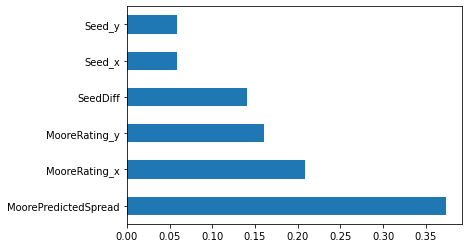

In [20]:
features(110)

<AxesSubplot:>

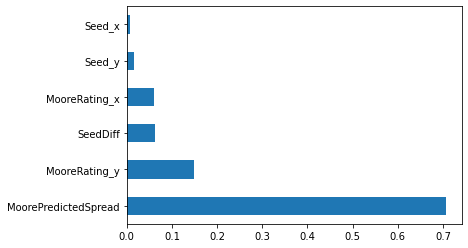

In [21]:
features(21)

In [22]:
final_results.to_csv('mydata/womens/training_results_spread.csv', index = False)

In [23]:
params(319)

"{'eta': 3, 'max_depth': 2, 'min_child_weight': 6, 'gamma': 1, 'subsample': 0.6, 'lambda': 0.3, 'random_state': 0}"

In [24]:
params(260)

"{'max_features': 3, 'max_depth': 6, 'min_samples_leaf': 0.0003}"

In [25]:
xgb_params = {'eta': 3, 'max_depth': 2, 'min_child_weight': 6, 'gamma': 1, 'subsample': 0.6, 'lambda': 0.3, 'random_state': 0}
rf_params = {'max_features': 3, 'max_depth': 6, 'min_samples_leaf': 0.0003}
xgb_model = XGBRegressor(**xgb_params).fit(X_no_stats.drop(columns = ['Season']), y_no_stats)
rf_model = RandomForestRegressor(n_estimators = 500,
                                         max_depth = rf_params['max_depth'],
                                         min_samples_leaf = rf_params['min_samples_leaf'],
                                         max_features = rf_params['max_features'],
                                         random_state = 0).fit(X_no_stats.drop(columns = ['Season']), y_no_stats)

In [26]:
pickle.dump(xgb_model, open('models/WSpreadXGB.sav', 'wb'))
pickle.dump(rf_model, open('models/WSpreadRF.sav', 'wb'))